<img src="images/banner.png" alt="Folded outcrop" />

# Faulted refolded folds

### Imports

In [1]:
import sys, os, subprocess
import matplotlib.pyplot as plt
# adjust some settings for matplotlib
from matplotlib import rcParams
import numpy as np
import scipy
import scipy.fftpack
from LoopStructural.visualisation import LavaVuModelViewer
from LoopStructural.utils.helper import strike_dip_vector
from LoopStructural import GeologicalModel
import LoopStructural
import pandas as pd
# print rcParams
rcParams['font.size'] = 15
# determine path of repository to set paths corretly below
repo_path = os.path.realpath('../..')
sys.path.append(repo_path)
import pynoddy.history
import logging
logging.getLogger().setLevel(logging.INFO)

### Load data and define model box

In [2]:
df2 = pd.read_csv('faulted_type1.csv')
bb = np.zeros((2,3))
bb[1,:] =(10000.0, 7000.0, 5000.0)

### View the data
Have a look at the contents of the data frame, we can see there are a number of columns e.g strike, dip, value, coord, type etc. These are used by LoopStructural to constrain the interpolator. The column type contains our identifier for which scalar field the data points are constraining e.g. the fault, s1 or s0. 

In [15]:
df2

,Unnamed: 0,X,Y,Z,val,coord,type,dip,strike,event,Unnamed: 6
0,0,5500.000000,2500.000000,4000.0,0.0,0,fault,NaN,NaN,NaN,NaN
1,1,5500.000000,2500.000000,4000.0,0.0,0,fault,NaN,NaN,NaN,NaN
2,2,1.000000,2500.000000,4000.0,0.0,1,fault,NaN,NaN,NaN,NaN
3,3,7000.000000,2500.000000,4000.0,1.0,1,fault,NaN,NaN,NaN,NaN
4,4,1.000000,2500.000000,1000.0,0.0,2,fault,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
241,176,2015.987000,4323.256743,4000.0,NaN,1,s1,90.0,269.999654,1.0,NaN
242,181,7080.901008,3038.250421,4000.0,NaN,1,s1,90.0,89.999654,1.0,NaN
243,186,5132.414407,5411.000695,4000.0,NaN,1,s1,90.0,89.999654,1.0,NaN
244,191,8598.085637,5141.728218,4000.0,NaN,1,s1,90.0,269.999654,1.0,NaN


In [16]:
df2.type.unique()

array(['fault', nan, 's1', 's0'], dtype=object)

### Setting up the model
Below we can set up the model, first we need to know which order these geological features occured. In this example the fault is the most recent feature, and then the s1 foliation and then the primary foliation (s0).

Therefore to create the model we add these features in the reverse order:
1. Fault
2. s1
3. s0 

### Creating the fault frame

05:36:46 INFO:Creating regular tetrahedron mesh with 25500 elements 
for modelling using PLI
05:36:46 INFO:Building fault coordinate 0
05:36:46 INFO:Adding 0 faults to fault_0
05:36:46 INFO:Setting up PLI interpolator for fault_0
05:36:47 INFO:Using constant gradient regularisation w = 0.100000
05:36:47 INFO:Added 0 gradient constraints, 40 normal constraints,0 tangent constraints and 2 value constraintsto fault_0
05:36:47 INFO:Interpolation matrix is 49332 x 6048
05:36:47 INFO:Adding eps to matrix diagonal
05:36:47 INFO:Solving using scipy LU
05:36:48 INFO:Building fault coordinate 2
05:36:49 INFO:Adding 0 faults to fault_2
05:36:49 INFO:Setting up PLI interpolator for fault_2
05:36:49 INFO:Using constant gradient regularisation w = 0.100000
05:36:49 INFO:Added 0 gradient constraints, 0 normal constraints,0 tangent constraints and 2 value constraintsto fault_2
05:36:49 INFO:Interpolation matrix is 74712 x 6048
05:36:49 INFO:Adding eps to matrix diagonal
05:36:49 INFO:Solving using sci


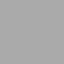

In [19]:
model = GeologicalModel(bb[0,:],bb[1,:])
model.set_model_data(df2)
fault = model.create_and_add_fault('fault',
                                   -500,
                                   nelements=1e4,
                                   interpolatottype='PLI',
                                   buffer=0.7,
                                   solver='lu'
                                  )
viewer = LavaVuModelViewer(model)
viewer.add_isosurface(fault['feature'][0],
                     isovalue=0)
viewer.add_vector_field(fault['feature'][1],locations=model.regular_grid()[::50])
viewer.interactive()

### Creating the fold frame

05:36:55 INFO:Creating regular tetrahedron mesh with 25500 elements 
for modelling using PLI
05:36:55 INFO:Building s1 coordinate 0
05:36:55 INFO:Adding 1 faults to s1_0
05:36:56 INFO:Setting up PLI interpolator for s1_0
05:36:56 INFO:Using constant gradient regularisation w = 0.100000
05:36:56 INFO:Added 0 gradient constraints, 40 normal constraints,0 tangent constraints and 0 value constraintsto s1_0
05:36:56 INFO:Interpolation matrix is 49330 x 6048
05:36:56 INFO:Adding eps to matrix diagonal
05:36:56 INFO:Solving using scipy LU
05:36:58 INFO:Building s1 coordinate 1
05:36:59 WARNING:Constraints contain nan not adding constraints
05:36:59 INFO:Adding 1 faults to s1_1
05:36:59 INFO:Setting up PLI interpolator for s1_1
05:37:00 INFO:Using constant gradient regularisation w = 0.100000
05:37:00 INFO:Added 0 gradient constraints, 40 normal constraints,0 tangent constraints and 0 value constraintsto s1_1
05:37:00 INFO:Interpolation matrix is 49330 x 6048
05:37:00 INFO:Adding eps to matrix


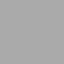

In [20]:
fold_frame = model.create_and_add_fold_frame('s1',
                                nelements=1e4,
                                            regularisation=[1.,1.,.1],
                                            interpolatortype='PLI',
#                                             gxxgy=0.,
                                            solver='lu',
                                            damp=True,
                                            buffer=0.7)

viewer = LavaVuModelViewer(model)
viewer.add_isosurface(fault['feature'][0],
                     isovalue=0)
viewer.add_isosurface(fold_frame['feature'][0],
                     isovalue=0)
viewer.interactive()


### Interpolating bedding

05:37:44 INFO:Creating regular tetrahedron mesh with 21280 elements 
for modelling using DFI
05:37:44 INFO:Adding 1 faults to s0
05:37:44 INFO:Fitted: 0.002723 -0.013975 -0.012700 1.333314
05:37:44 INFO:Not using fold axis for fold limb rotation angle calculation
05:37:44 INFO:Guess: 0.000000 0.000000 0.000000 1.785314
05:37:44 INFO:There are 0 nans for the fold limb rotation angle and 40 observations
05:37:44 INFO:Fitted: 0.001678 0.015499 -0.006846 1.661184
05:37:44 INFO:Adding fold to s0
05:37:44 INFO:Using fold_axis_rotation function
05:37:47 INFO:Adding fold orientation constraint to s0 w = 10.000000
05:37:48 INFO:Adding fold axis constraint to s0 w = 10.000000
05:37:48 INFO:Adding fold normalisation constraint to s0 w = 1.000000
05:37:48 INFO:Adding fold regularisation constraint to s0 w = 0.100000
05:37:48 INFO:Setting up PLI interpolator for s0
05:37:48 INFO:Added 40 gradient constraints, 0 normal constraints,0 tangent constraints and 0 value constraintsto s0
05:37:48 INFO:Inte


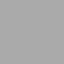

In [21]:
s0 = model.create_and_add_folded_foliation('s0',
                                           fold_frame=fold_frame['feature'],
                                      nelements=1e4,
                                          solver='lu',
                                          buffer=0.5,
                                          damp=True)
viewer = LavaVuModelViewer(model)

viewer.add_vector_field(fold_frame['feature'][1],
                       locations=s0['feature'].builder.interpolator.get_gradient_constraints()[:,:3]
                       )


viewer.add_isosurface(fold_frame['feature'][1],
                     isovalue=0)

viewer.add_data(fold_frame['feature'][1])

viewer.add_scalar_field(s0['feature'],cmap='tab20')

viewer.add_isosurface(s0['feature'])
viewer.add_data(s0['feature'])
viewer.interactive()

In [35]:
viewer.lv.image('images\example5.png')

'images\\example5.png'

### Fold axis rotation angle 

(-90, 90)

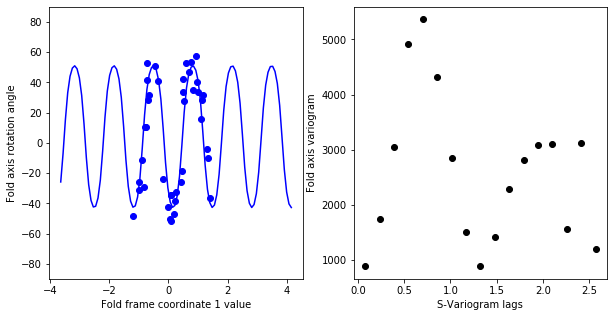

In [26]:
fig, ax = plt.subplots(1,2,figsize=(10,5),)
x = np.linspace(fold_frame['feature'][1].min(),fold_frame['feature'][1].max(),100)
ax[0].plot(s0['axis_direction'],s0['axis_rotation'],'bo')
ax[0].plot(x, s0['fold'].fold_axis_rotation(x),'b-')
ax[0].set_ylabel('Fold axis rotation angle')
ax[0].set_xlabel('Fold frame coordinate 1 value')


ax[1].plot(s0['axis_svariogram'].lags,s0['axis_svariogram'].variogram,'ko')
ax[1].set_ylabel('Fold axis variogram')
ax[1].set_xlabel('S-Variogram lags')


ax[0].set_ylim(-90,90)

### Fold limb rotation angle

(-90, 90)

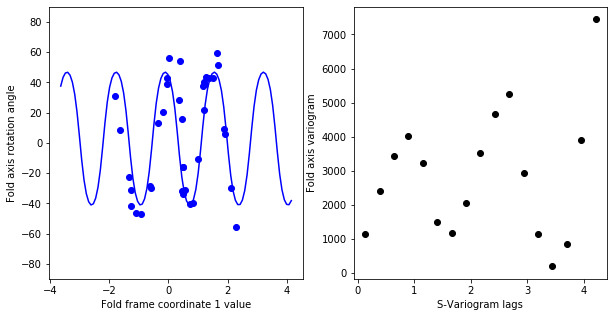

In [28]:
fig, ax = plt.subplots(1,2,figsize=(10,5),)
x = np.linspace(fold_frame['feature'][1].min(),fold_frame['feature'][1].max(),100)
ax[0].plot(s0['foliation'],s0['limb_rotation'],'bo')
ax[0].plot(x, s0['fold'].fold_limb_rotation(x),'b-')
ax[0].set_ylabel('Fold axis rotation angle')
ax[0].set_xlabel('Fold frame coordinate 1 value')


ax[1].plot(s0['limb_svariogram'].lags,s0['limb_svariogram'].variogram,'ko')
ax[1].set_ylabel('Fold axis variogram')
ax[1].set_xlabel('S-Variogram lags')


ax[0].set_ylim(-90,90)


(0.0, 0.7)

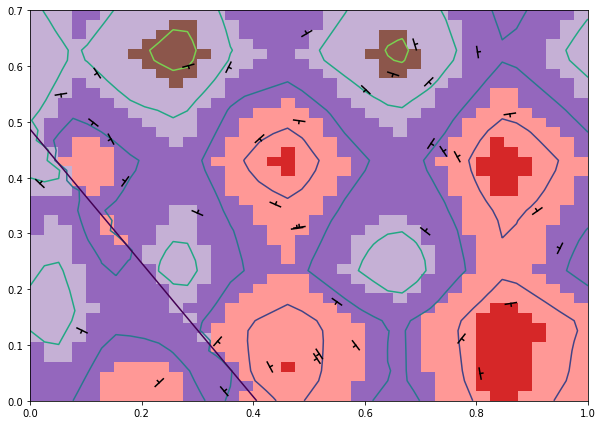

In [32]:
from LoopStructural.visualisation import MapView
mapview = MapView(model)
mapview.nsteps = np.array([40,40])
mapview.add_data(s0['feature'],scale=0.02)
mapview.add_scalar_field(s0['feature'],cmap='tab20')
mapview.add_contour(s0['feature'],4)
mapview.add_contour(fault['feature'][0],[0])
plt.xlim(model.bounding_box[0,0],model.bounding_box[1,0])
plt.ylim(model.bounding_box[0,1],model.bounding_box[1,1])